# Synopsis

The number of bonds between two atoms is an interresting feature to play with but is not provided with the competition data.

This kernel builds a dataset with the reconstructed bonding scheme for each molecule:  
* The algorithm used to do so is to build a spanning tree conecting each atom of the molecule. 
* Connection are made based on the expecting bonding distance for each pair of nearby atoms.  
* A partial ionized group detection is performed.  
* Shortest cycles are detected.

Note: There is another alternative to build bonding data, which I've not tested yet, see post here:  
[Helpful Information: How to obtain bonding data](Helpful Information: How to obtain bonding data)

## Changelog

* V4 : manual inspection of one molecule failing bond matching : dsgdb9nsd_000271 = alanine isomere
* V5 : added Ase 3D mouse visualization for alanine "bug"
* V6 : added support for ionized molecules and `4N` bonds after discovering the [zwitterionic](https://en.wikipedia.org/wiki/Zwitterion) form of alanine in `dsgdb9nsd_000202`. Changed type from `1CH` to `1.0CH`
* V9 : added cycle detection code with statistics and examples
* V11: save cycles in .csv output files

## Table `train_bonds` and `test_bonds`
The [Output Dataset](https://www.kaggle.com/asauve/predicting-molecular-properties-bonds) will be updated following bond detction improvements. 
It is built with the same keys as for the competition tables `structure` and `train`/`test`.

Tables `train_bonds` and `test_bonds` have one row per bond :
```
molecule_name | atom_index_0 | atom_index_1 | nbond | error | bond_type
```
* `nbond` is the number of covalent bonds between `atom_index_0` (relative to `structure`) and `atom_index_1`. It can take values `1.5` for `COO-` groups.
* `error` is `0` if the molecule has a  consistent reconstruction (meaning that each atom has the expected number ofcovalent bonds). 
Otherwise it is set to `1` for each bond of the molecule
* `bond_type` is <nbond><atom0><atom1>. Atom appear in lexicographic order to ensure unicity for 2 atoms combination.   
    Example: `1.0CH`, `2.0CC`,  `1.5CO`

## Table `train_charges` and `test_charges`
It has been found that some molecules are ionized after discovering the zwiterionic form of *beta-alanine* in molecule `dsgdb9nsd_000202`.  
Hence support for atom charge has been included in tables `train_charges` and `test_charges`, plus an optional 4th bond for `N`. 
These tables have the very same key as `structure` and one row is:
```
molecule_name | atom_index | charge
```
* charge can be `0`, `-1`, `+0.5` (for `O` in carboxyle) or `+1` (may evolve if needed)

## Table `train_cycles` and `test_cycles`

Cycles are detected and stored in a separated table because one atom can be a member of several cycles.  
These tables have the very same key as `structure` and one row is:
```
molecule_name | cycle_index | cycle_seq | atom_index
```
* `cycle_index` starts from zero and allow to select one cycle
* `cycle_seq` is the index of atom in the cycle sequence.
It is guaranteed that two consecutive atoms in *cycle sequence* have a covalent bond.
* `atom_index` is the atom idex from table `structure` which can be member of several cycle.   

# General information

![](https://storage.googleapis.com/kaggle-competitions/kaggle/14313/logos/thumb76_76.png?t=2019-05-16-16-56-19)

This kernel uses data from [Predicting Molecular Properties](https://www.kaggle.com/c/champs-scalar-coupling) which is intended to predict interactions between atoms in the domain of Nuclar Magnetic Resonnance (NMR). More precisely it is the *scalar coupling constant* between atoms which is to be predicted.

As this challenge is based uppon molecular topological properties, it can be useful to have an appropriate way of representing molecules.
These visualizations can then be used to infer useful hints to understand the coupling properties, engineer appropriate features and debug
prediction failures.



# Others Work

* [Is type related to scalar coupling? EDA](https://www.kaggle.com/hrmello/is-type-related-to-scalar-coupling)  
"ALL 1JHC couplings are above 60."
* [Competition metric](https://www.kaggle.com/abhishek/competition-metric)
* [Molecular Properties EDA and models](https://www.kaggle.com/artgor/molecular-properties-eda-and-models)   
this kernel scores 0.626 and uses features `dist_speedup` which is atoms relative distance calculated with L2 norm
* [Exploring Molecular Properties Data](https://www.kaggle.com/robikscube/exploring-molecular-properties-data)   
propose a nice exploratory work on extraneous features in the train dataset
* [How To: Easy Visualization of Molecules.](https://www.kaggle.com/borisdee/how-to-easy-visualization-of-molecules/comments)  
Boris shows in  this kernel hos to use the Ase library for mouse movable molecular display (no bond type support)

# Load data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from ase import Atoms  # 3D mouse clickable funky visualization
import ase.visualize
import networkx as nx # for cycle detection

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os
print("Modules loading Done!")

Modules loading Done!


In [2]:
csv_files = [ "train.csv", "test.csv", "structures.csv" ]
csv_vars  = [ filename[:-4] for filename in csv_files ]
for filename, var in zip( csv_files, csv_vars ):
    eval_str = f"{var:32s} = pd.read_csv('../input/{filename}')"
    print(eval_str)
    exec(eval_str)
    print(f"{'nb of cols ':32s}= "+str(eval(f"len({var})")))
    exec(f"display({var}.head())")


train                            = pd.read_csv('../input/train.csv')
nb of cols                      = 4658147


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


test                             = pd.read_csv('../input/test.csv')
nb of cols                      = 2505542


,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


structures                       = pd.read_csv('../input/structures.csv')
nb of cols                      = 2358657


,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


# Molecule display code

The following code snipet (unhide to see) is taken from [Training set molecule visualization](https://www.kaggle.com/asauve/training-set-molecule-visualization). 
It builds a 3D molecule visualization with 
* scalar_coupling_constant as transparent connections: thickness is a factor of scalar value
  * plain for 1J spin-spin coupling
  * dashed for 2J
  * dotted for 3J
* covalent bonds are drawn as black lines: thickness increase with number of bonds

In [3]:
def view3d_molecule(name):
    m = structures[structures.molecule_name == name]
    positions = m[['x','y','z']].values
    # pip install ase
    return ase.visualize.view(Atoms(positions=positions, symbols=m.atom.values), 
                              viewer="x3d") 
cpk = { 
    'C': ("black", 2),
    'H': ("white", 1),
    'O': ("red",   2),
    'N': ("blue", 2),
    'F': ("green", 2) }

bond_colors = {'1.0':'black', '1.5':'darkgreen', '2.0':'green', '3.0':'red'}

def bond_type_to_pair(bond_type):
    return bond_type[3:]
def bond_type_to_n(bond_type):
    return bond_type[0:3]

def plot_molecule(name, ax=None, bonds=None, charges=None, elev=0, azim=-60):
    """bonds = if provided add bonds display from the bond table dataset in https://www.kaggle.com/asauve/predicting-molecular-properties-bonds
    elev = 3D elevation angle [degree] for the molecule view
    azim = 3D azimut angle [degree]
    """
    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    if (elev != 0) or (azim != -60):
        ax.view_init(elev=elev, azim=azim)
    
    # atoms location
    m = structures[structures.molecule_name == name].sort_values(by='atom_index')
    if (charges is not None):
        charges = charges[charges.molecule_name == name].sort_values(by='atom_index')
        if len(charges) != len(m):
            print(f"Warning bad charges data for molecule {name}")
    
    # formula
    acount = {a : 0 for a in cpk}
    for a in m.atom:
        acount[a] += 1
    formula = ""
    for a in acount:
        if acount[a] == 1:
            formula += a
        elif acount[a] > 1:
            formula += "%s_{%d}" % (a, acount[a])

    ax.set_title(f'{name} ${formula}$')
    
    # display couplings (coupling is not molecular bonds!)
    couples = train[train.molecule_name == name][['atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
    for c in couples.itertuples():
        m0 = m[m.atom_index == c.atom_index_0]
        m1 = m[m.atom_index == c.atom_index_1]
        ax.plot([float(m0.x), float(m1.x)],[float(m0.y), float(m1.y)],[float(m0.z), float(m1.z)],
               linestyle = ['', '-', '--', 'dotted'][int(c.type[0])],
               color     = ['', 'black', 'green', 'red' ][int(c.type[0])],
               linewidth = abs(float(c.scalar_coupling_constant))/5,
               alpha=0.2), 
    if bonds is not None:
        for b in bonds[bonds.molecule_name == name].itertuples():
            m0 = m[m.atom_index == b.atom_index_0]
            m1 = m[m.atom_index == b.atom_index_1]
            ax.plot([float(m0.x), float(m1.x)],[float(m0.y), float(m1.y)],[float(m0.z), float(m1.z)], 'black', 
                    linewidth=2*float(b.nbond),
                    color=bond_colors[bond_type_to_n(b.bond_type)])
            
    # display atoms
    ax.scatter(m.x, m.y, m.z, c=[cpk[a][0] for a in m.atom], s=[100*cpk[a][1] for a in m.atom], edgecolor='black')
        
    # display atom index and charges
    for row in m.itertuples():
        x = float(row.x) - 0.15 if row.x > ax.get_xlim()[0] + 0.15 else row.x
        y = float(row.y) - 0.15 if row.y > ax.get_ylim()[0] + 0.15 else row.y
        z = float(row.z) - 0.15 if row.z > ax.get_zlim()[0] + 0.15 else row.z
        ax.text(x, y, z, str(row.atom_index), color='darkviolet')
        if charges is not None:
            ch = float(charges[charges.atom_index == row.atom_index].charge)
            if ch != 0:
                x = float(row.x) + 0.15 if row.x < ax.get_xlim()[1] - 0.15 else row.x
                y = float(row.y) + 0.15 if row.y > ax.get_ylim()[1] - 0.15 else row.y
                z = float(row.z) + 0.15 if row.z < ax.get_zlim()[1] - 0.15 else row.z
                ax.text(x, y, z, f"{ch:+.1f}", color='orangered' if ch > 0 else 'blue',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, 
                                  edgecolor='black'))
#plot_molecule("dsgdb9nsd_000140", bonds=train_bonds, charges=train_charges)

This example shows the three kind of coupling types. The 1 bond coupling having the largest coupling constant.

# Bonds reconstruction algorithm

Useful links :
* <a href="https://en.wikipedia.org/wiki/Atomic_radii_of_the_elements_(data_page)">Atomic radii of the elements</a>

The algorithm for bond selection is
* Select a molecule
* **STEP 1** : 1-bond connect   
 For each atom
    * For each #VALENCE closest match:
        * does the distance correspond to the expected bond distance?
            * does both atoms have remaining bonds?
              * decease remaining valence and create bond
              * mark both atoms as leaf if one of them has zero remaining valence
* **STEP 2** : n-bond greedy connect   
While there are remaining leafs atoms with available valence
    * For each connected neighbour 
      * add as many bonds as possible
      * mark both connected atoms as leaf
* **STEP 3** : ionized radical search
If there are remaining valence on some atoms
    * Look for disconnected NH3  => convert to connected NH3+
    * Look for O with one available bond connected to CO => convert to COO-
    * Other cases may be handled later
* **STEP 4** : cycle search
    * Use `networkx` pip library for shortest cycle detection
    * Index atoms by order in their respective cycle
* **CHECK**   
Has any atom remaining valence > 0?
    * mark the molecule with error=1
  

In [4]:
from scipy.spatial import cKDTree as KDTree
from tqdm import tqdm_notebook as tqdm


# "usual" valence of atoms
VALENCE_MAX = { 'C': 4, 'H' : 1, 'N' : 4, 'O' : 2, 'F': 1 }
VALENCE_STD = { 'C': 4, 'H' : 1, 'N' : 3, 'O' : 2, 'F': 1 }

# expected distances in [A] for covalence 1 bond
BOND_DIST_C1 = { 'C' : 0.77, 'H' : 0.38, 'N' : 0.75, 'O' : 0.73, 'F' : 0.71 }

# order used for finding bonds by atom type
BOND_ORDER = { 'H' : 0, 'F' : 0, 'O' : 1, 'N' : 2, 'C' : 3}

def add_bond(n_avail, nbond, a0, a1, d1=None):
    key = tuple(sorted((a0, a1)))
    if key in nbond:
        nbond[key][0] += 1.0
    elif d1 is not None:
        nbond[key] = [1.0, d1]
    else:
        raise Exception(f"{a0},{a1} added after phase 1")
    n_avail[a0] -= 1
    n_avail[a1] -= 1
    #display(f"{a0},{a1} => {n_avail}, {nbond}")

def get_bonded_atoms(atoms, nbond, i):
    """returns: [sorted atoms list], [sorted atom index] )"""
    bonded = []
    for (a0, a1), (n, _) in nbond.items():
        if a0 == i:
            bonded.append((a1, atoms[a1]))
        elif a1 == i:
            bonded.append((a0, atoms[a0]))
    bonded = sorted(bonded, key=lambda b: b[1])
    return "".join([b[1] for b in bonded]), [b[0] for b in bonded]


def search_bonds(kdt, n_avail, nbond, connected, isleaf, coords, atoms, atoms_idx, a0, 
                 connect_once=True, VALENCE=VALENCE_STD):
    atom0 = atoms[a0]
    if n_avail[a0] == 0:
        return

    # select closest atoms ORDERED BY DISTANCE: closest first
    # note: the first answer is the atom itself and must be removed
    next_dist, next_i = kdt.query(coords[a0], min(1+VALENCE[atom0], len(atoms)))
    next_dist = next_dist[1:]; # remove a0 from list
    next_i = next_i[1:]

    # for each #VALENCE closest atoms
    found = False
    for d1,a1 in zip(next_dist, next_i):
        if connect_once and (a1 in connected[a0]):
            continue  # enforce 1-bond only in STEP 1
        atom1 = atoms[a1]
        predicted_bond = BOND_DIST_C1[atom0] + BOND_DIST_C1[atom1]
        if abs(d1 / predicted_bond) < 1.2: # keep only atoms in the 20% expected distance or closer
            if n_avail[a1] > 0:
                add_bond(n_avail, nbond, a0, a1, d1)
                connected[a0][a1] = 1
                connected[a1][a0] = 1
                if (n_avail[a0] == 0) or (n_avail[a1] == 0):
                    isleaf[a0] = 1
                    isleaf[a1] = 1
                found = True
                #print("leaF/Trunk & avail: "+ ", ".join([f"{i}:{atoms[i]}={leaflabel[isleaf[i]]}{n_avail[i]}"
                #                 for i in ordered_atoms_index]))

        else:
            #print(f"-- match failure in molecule_name={name} {a0}:{atom0}-{a1}:{atoms[a1]}={d1} predicted={predicted_bond}")
            pass
    return found
    
def compute_bonds(structures, molecules):
    out_name = []; out_a0 = []; out_a1 = []; out_n = []; out_dist = []; out_error = []; out_type = []
    cycle_name = []; cycle_index = []; cycle_seq = [];  cycle_atom_index = []
    charge_name = []; charge_atom_index = []; charge_value = [];
    for imol,name in tqdm(list(enumerate(molecules))):
        molecule = structures.loc[name ]
        error    = 0
        atoms    = molecule.atom.values
        atoms_idx= molecule.atom_index.values
        
        n_avail  = np.asarray([VALENCE_STD[a] for a in atoms])
        n_charge = np.zeros(len(atoms), dtype=np.float16)
        isleaf   = np.zeros(len(atoms), dtype=np.bool) # is the atom in the leafs of connection tree?
        coords   = molecule[['x', 'y', 'z']].values
        kdt = KDTree(coords) # use an optimized structure for closest match query
        nbond = {}
        connected = { i:{} for i in atoms_idx}
        
        # select Hydrogen first to avoid butadyne-like ordering failures (molecule_name=dsgdb9nsd_000023)
        ordered_atoms_index = list(atoms_idx)
        ordered_atoms_index.sort(key = lambda i: BOND_ORDER[atoms[i]])
        ordered_atoms_index = np.asarray(ordered_atoms_index)
        
        # STEP 1: 1-bond connect each atom with closest match
        #         only one bond for each atom pair is done in step 1
        for a0 in ordered_atoms_index:
            search_bonds(kdt, n_avail, nbond, connected, isleaf, coords, atoms, atoms_idx, a0,
                         connect_once=True, VALENCE=VALENCE_STD)
     
        # STEP 2: greedy connect n-bonds, progressing from leafs of connection tree
        while (((n_avail > 0).sum() > 0) and isleaf).sum() > 0:
            progress = False
            for a0 in ordered_atoms_index:
                #print("leaF/Trunk & avail: " + ", ".join([f"{i}:{atoms[i]}={leaflabel[leaf[i]]}{n_avail[i]}"
                #                                          for i in ordered_atoms_index]))
                if (n_avail[a0] > 0) and isleaf[a0]:
                    for a1 in connected[a0]:
                        if (n_avail[a0] > 0) and (n_avail[a1] > 0):
                            add_bond(n_avail, nbond, a0, a1) 
                            progress = True
                            if (n_avail[a0] == 0) or (n_avail[a1] == 0):
                                isleaf[a0] = 1
                                isleaf[a1] = 1
            if not progress:
                break
        
        # gather remaining multiple bonds
        if n_avail.sum() > 0:
            for key in nbond.keys():
                a0, a1 = key
                while (n_avail[a0] > 0) and (n_avail[a1] > 0):
                    add_bond(n_avail, nbond, a0, a1)
    
        # STEP 3: search for known ionized radicals
        if n_avail.sum() > 0:
            for (i,a) in zip(atoms_idx, atoms):
                if a == 'N':
                    # NH3+
                    bonded_str, bonded_idx = get_bonded_atoms(atoms, nbond, i)
                    if (bonded_str == "HHH") and (n_avail[i] == 0):
                        # add a valence unit and search a dangling bond nearby
                        n_avail[i] += 1; n_charge[i] += 1
                        if search_bonds(kdt, n_avail, nbond, connected, isleaf, coords, atoms, atoms_idx,
                                        i, connect_once=False, VALENCE=VALENCE_MAX):
                            print(f"++ NH3+ found for {name} atom_index={i}")
                        else:
                            print(f"** NH3+ bonding failure for {name} atom_index={i}")
                            
                elif (a == 'O') and (n_avail[i] == 1):
                    # COO-
                    bonded_str, bonded_idx = get_bonded_atoms(atoms, nbond, i)
                    if bonded_str == "C":
                        C_i = bonded_idx[0]
                        C_bonded_str, C_bonded_idx = get_bonded_atoms(atoms, nbond, C_i)
                        if ("OO" in C_bonded_str):
                            has_2CO = False 
                            #print (C_bonded_str, C_bonded_idx, nbond, name)
                            for a1, i1 in zip(C_bonded_str, C_bonded_idx):
                                key = tuple(sorted((C_i, i1)))
                                if (a1 == 'O') and  (nbond[key][0] == 2):
                                    has_2CO = True
                            if (len(C_bonded_idx) == 3) and has_2CO:
                                # found carboxyle!
                                n_avail[i] -= 1
                                print(f"**  COO- found for {name} C_atom_index={C_i}")
                                for a1, i1 in zip(C_bonded_str, C_bonded_idx):
                                    if a1 == 'O':
                                        n_charge[i1] = -0.5
                                        key = tuple(sorted((C_i, i1)))
                                        nbond[key][0] = 1.5                    
                                    
        # detect cycles : algo complexity in O(m^2 * n)
        #    paper : https://link.springer.com/article/10.1007/s00453-007-9064-z
        #    nx doc: https://networkx.github.io/documentation/latest/reference/algorithms/generated/networkx.algorithms.cycles.minimum_cycle_basis.html
        graph = nx.Graph([bond for bond in nbond.keys()])
        unordered_cycles = nx.minimum_cycle_basis(graph)
        
        # index atoms by their sequential order in the cycle: i.e follow bonds
        # Note: this code can be written in a much cleaner way!
        if len(unordered_cycles) > 0:
            for icycle, c in enumerate(unordered_cycles):
                available = {i:1 for i in c}
                a0 = c[0]
                cycle = [ a0 ]
                del(available[a0])
                for index in range(1, len(c)):
                    # get atoms bonded to a0
                    bonded = [ b for b in nbond.keys() if a0 in b ]
                    bonded = list(map(lambda b: b[0] if b[1] == a0 else b[1], bonded))
                    
                    # get next atom and remove it from cycle
                    assert(len(bonded) > 0)
                    found = False
                    for a1 in bonded:
                        if (a1 in bonded) and (a1 in available):
                            cycle.append(a1)
                            del(available[a1])
                            a0 = a1
                            found = True
                            break
                    assert(found)
                    
                # and add cycles found to the cycle dataframe lists
                cycle_name.extend([name] * len(cycle))
                cycle_index.extend([icycle] * len(cycle))
                cycle_seq.extend(np.arange(len(cycle)))
                cycle_atom_index.extend(cycle)
        
        # display info on failed molecules
        if n_avail.sum() > 0:
            error = 1
            print(f"   Remaining bondings={n_avail.sum()} for molecule_name={name}, atoms: " +
                  ", ".join([f"{i}:{atoms[i]}" for i in atoms_idx if n_avail[i] > 0]))

        # inputs for DataFrame bonds
        for (a0, a1), (n, dist) in nbond.items():
            # append to python lists which is 7x faster than toa pd.DataFrame
            out_name.append(name); out_a0.append(a0); out_a1.append(a1); out_n.append(n)
            out_dist.append(dist); out_error.append(error)
            out_type.append(f"{n:0.1f}" + "".join(sorted(f"{atoms[a0]}{atoms[a1]}")) )
    
        # inputs for DataFrame charges
        charge_name.extend(        [name] * len(atoms) )
        charge_atom_index.extend(  molecule.atom_index.values )
        charge_value.extend(       n_charge )
        
    bonds = pd.DataFrame({'molecule_name':out_name, 'atom_index_0':out_a0,'atom_index_1':out_a1, 'nbond':out_n, 
                          'L2dist':out_dist, 'error':out_error, 'bond_type':out_type})
    charges = pd.DataFrame({'molecule_name':charge_name, 'atom_index':charge_atom_index, 
                            'charge': charge_value})
    cycles = pd.DataFrame({'molecule_name' : cycle_name, 'cycle_index' : cycle_index, 
                           'cycle_seq' : cycle_seq, 'atom_index' : cycle_atom_index})
    return bonds, charges, cycles
            


# Build bonds for train / test sets

In [5]:
train_bonds, train_charges , train_cycles = \
    compute_bonds(structures.set_index('molecule_name'), 
                  train.molecule_name.unique())
#debug_name = "dsgdb9nsd_000202"
#train_bonds, train_charges = compute_bonds(structures.set_index('molecule_name'), 
#                                           [ debug_name ])
#plot_molecule(debug_name, bonds=train_bonds, charges=train_charges)
#view3d_molecule(debug_name)

   Remaining bondings=2 for molecule_name=dsgdb9nsd_000202, atoms: 2:C, 4:C
++ NH3+ found for dsgdb9nsd_000271 atom_index=0
**  COO- found for dsgdb9nsd_000271 C_atom_index=6
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000731, atoms: 2:C, 4:N
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000761, atoms: 2:C, 4:N
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000840, atoms: 2:C, 4:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000842, atoms: 2:C, 4:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000854, atoms: 2:C, 4:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000855, atoms: 2:C, 4:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000910, atoms: 0:O, 3:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000912, atoms: 0:O, 3:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000982, atoms: 2:C, 5:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_001006, atoms: 0:C, 5:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_001007, atoms

In [6]:
test_bonds, test_charges, test_cycles = \
    compute_bonds(structures.set_index('molecule_name'), 
                  test.molecule_name.unique())


   Remaining bondings=2 for molecule_name=dsgdb9nsd_000204, atoms: 2:C, 4:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000206, atoms: 2:C, 4:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000208, atoms: 2:C, 4:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000210, atoms: 2:C, 4:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000211, atoms: 2:C, 4:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000282, atoms: 6:O, 7:O
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000724, atoms: 2:N, 5:N
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000782, atoms: 2:C, 4:N
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000843, atoms: 2:C, 4:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000909, atoms: 0:O, 3:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000911, atoms: 0:O, 3:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000968, atoms: 2:C, 5:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000974, atoms: 2:C, 5:C
   Remaining

In [7]:
print(f"Failed molecules ratio in test set = {test_bonds.groupby('molecule_name')['error'].max().sum() / len(test_bonds.molecule_name.unique()):0.3f}")
print(f"Failed molecules ratio in train set = {train_bonds.groupby('molecule_name')['error'].max().sum() / len(train_bonds.molecule_name.unique()):0.3f}")

test_nionized = test_charges.groupby('molecule_name')['charge'].apply(lambda arr: (arr.values != 0).max()).sum()
print(f"Ionized molecules ratio in test set = {test_nionized/len(test_bonds.molecule_name.unique()):0.3f}")

train_nionized = train_charges.groupby('molecule_name')['charge'].apply(lambda arr: (arr.values != 0).max()).sum()
print(f"Ionized molecules ratio in train set = {train_nionized/len(train_bonds.molecule_name.unique()):0.3f}")

print(f"{len(test_bonds.molecule_name.unique())} unique molecules in test set")
print(f"{len(train_bonds.molecule_name.unique())} unique molecules in train set")

Failed molecules ratio in test set = 0.025
Failed molecules ratio in train set = 0.024
Ionized molecules ratio in test set = 0.001
Ionized molecules ratio in train set = 0.001
45772 unique molecules in test set
85003 unique molecules in train set


# Check bond type consistency

## Distribution of bond length

Bond types:  ['1.0CH' '1.0HN' '1.0HO' '3.0CN' '1.0CC' '1.0CO' '3.0CC' '2.0CO' '1.0CN'
 '1.0NO' '2.0CN' '2.0CC' '1.0NN' '2.0NN' '1.5CO' '1.0CF' '2.0NO']


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


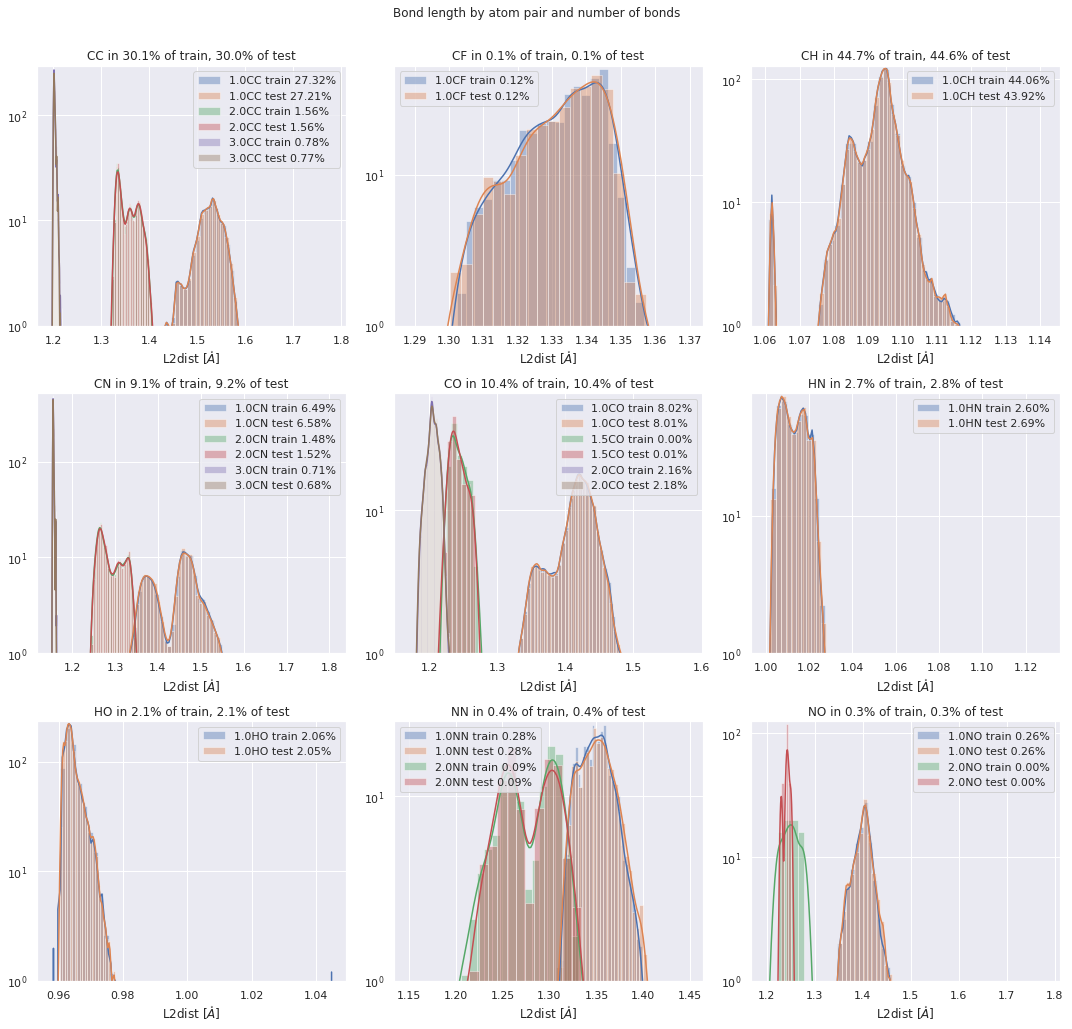

In [8]:
fig = plt.figure(figsize=(15,15))
bond_types = train_bonds.bond_type.unique()
unique_pairs = sorted({bond_type_to_pair(b):1 for b in bond_types}.keys())
print("Bond types: ", bond_types)
for (i, pair) in enumerate(unique_pairs):
    ax = fig.add_subplot(3, 3, i + 1)
    for bond_type in sorted([b for b in bond_types if pair == bond_type_to_pair(b)]):
        for (df, name) in [(train_bonds, "train"), (test_bonds, "test")]:
            #errors = df[(df.bond_type == bond_type) & (df.error == 1)].L2dist.values
            #if len(errors) > 0:
            #    sns.distplot(errors, color="red", kde=True)
            selection = df[(df.bond_type == bond_type) & (df.error == 0)].L2dist.values
            sns.distplot(selection, label=f"{bond_type} {name} {len(selection)/len(df)*100:.2f}%", kde=True, ax=ax)
    ax.set_ylim(1, ax.get_ylim()[1])
    ax.set_yscale('log')
    ax.set_xlabel("L2dist $[\mathring{A}]$")
    ratio_tr  = (train_bonds.bond_type.apply(bond_type_to_pair) == pair).sum() / len(train_bonds)
    ratio_tst = (test_bonds.bond_type.apply(bond_type_to_pair) == pair).sum() / len(test_bonds)
    ax.set_title(f"{pair} in {ratio_tr*100:.1f}% of train, {ratio_tst*100:.1f}% of test")
    ax.legend()
fig.suptitle("Bond length by atom pair and number of bonds")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


Train and test set does match very well for the relative distribution of bonds length. This is good news as the train and test should behave the same for the prediction of the *scalar coupling constant*.

The number of bond does also build distributions peaking at different bond distance, which is consistent with the expected behaviour: the number of bonds decrease the distance between atoms. The distribution of the `1.0CC`, `2.0CC` and `3.0CC` is a perfect example of very well separated distributions.

Adding the `COO-` handling improved a lot things by separating the previous `1CO` bimodal distribution into two well defined peaks, one for `1.5CO` and the second fonr `1.0C0`.  
=> some other bimodal distributions like `1.0CN`, which is contained in `6.5%` of bonds, can be expected to be resolved the same way if needed.


## Close analysis of `1.0CN` double peak in train set



/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


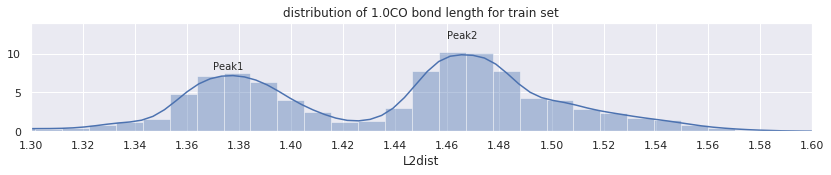

In [9]:
fig = plt.figure( figsize = (14,2) )
selection = train_bonds[(train_bonds.bond_type == '1.0CN') & (df.error == 0)].L2dist
ax = sns.distplot(selection, label=f"'1.0CN' {name} {len(selection)/len(df)*100:.2f}%", kde=True)
xticks = plt.xticks(np.linspace(1.3, 1.6, 16))
text = plt.title("distribution of 1.0CO bond length for train set")
ax.annotate("Peak1", (1.37, 8))
ax.annotate("Peak2", (1.46, 12))
xl = plt.xlim(1.3, 1.6)
yl = plt.ylim(0, 14)

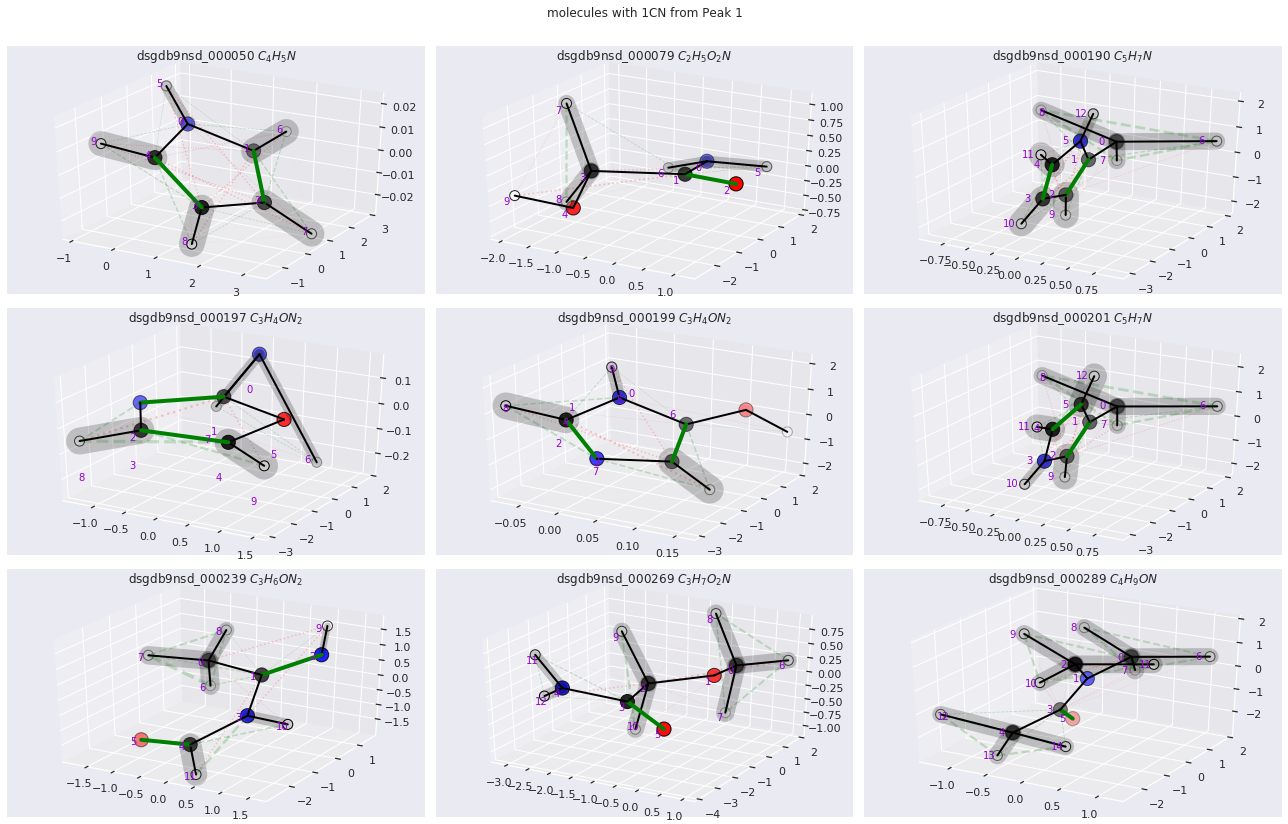

In [10]:
def select_range(df, l0, l1):
    return df[(df.bond_type == '1.0CN') & (df.error.values == 0) & (df.L2dist.values > l0) & (df.L2dist.values < l1)].molecule_name.unique()
peak1_molecules = select_range(train_bonds, 1.37, 1.375)
peak2_molecules = select_range(train_bonds, 1.465, 1.470)

ncols = 3
nrows = 3
fig1 = plt.figure(figsize = (18, 12))
for i in range(ncols*nrows):
    ax = fig1.add_subplot(nrows, ncols, i + 1, projection="3d")
    plot_molecule(peak1_molecules[i], bonds=train_bonds, charges=train_charges, ax=ax)
text = fig1.suptitle("molecules with 1CN from Peak 1")
fig1.tight_layout(rect=[0, 0.03, 1, 0.95])

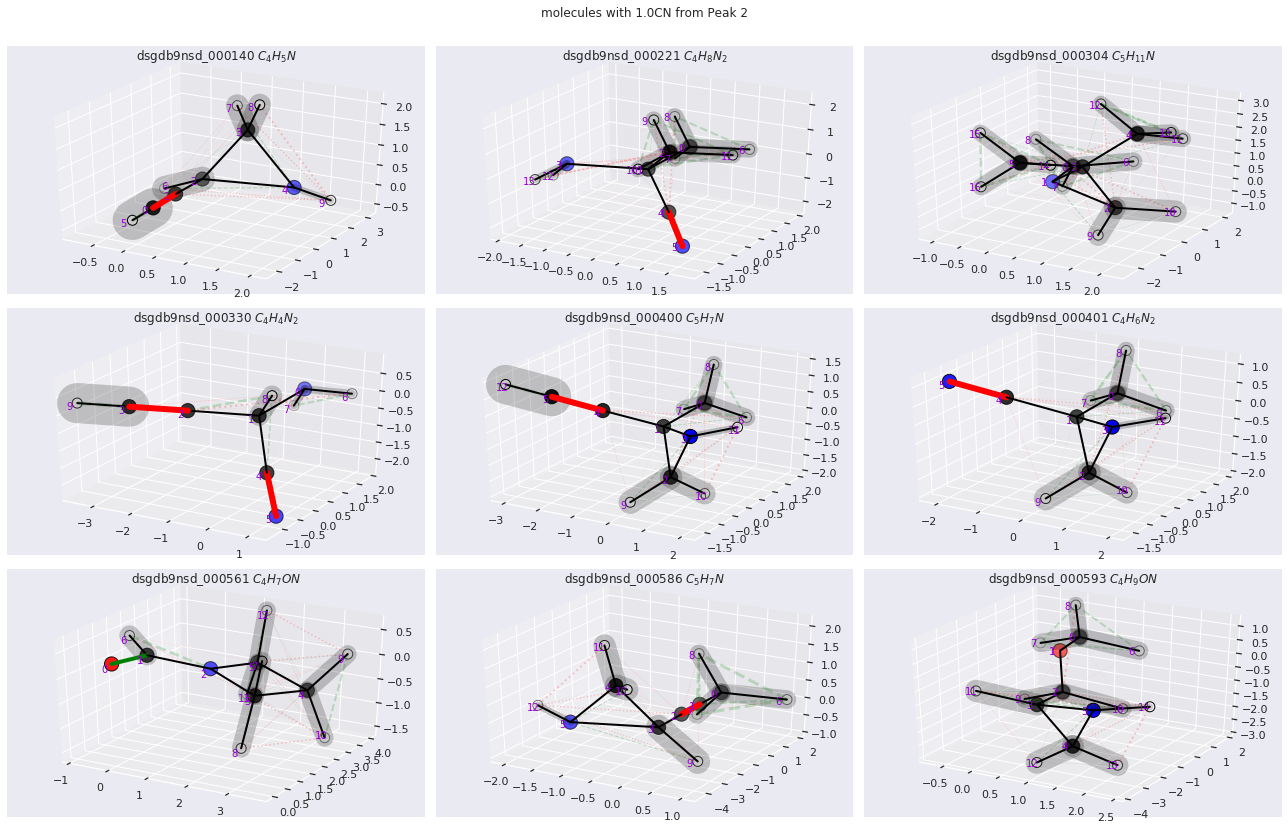

In [11]:
fig2 = plt.figure(figsize = (18, 12))
for i in range(ncols*nrows):
    ax = fig2.add_subplot(nrows, ncols, i + 1, projection="3d")
    plot_molecule(peak2_molecules[i], bonds=train_bonds, charges=train_charges, ax=ax)
text = fig2.suptitle("molecules with 1.0CN from Peak 2")
fig2.tight_layout(rect=[0, 0.03, 1, 0.95])

Double bonds are in green, and triple in red, for further details on the visualization see [Training set molecule visualization](https://www.kaggle.com/asauve/training-set-molecule-visualization?scriptVersionId=15133086).

The produced bonding schemes seems healthy for both set of molecules in the selected examples.

Observable differences in the selected set:
* For Peak 1 (shorter bonds): the C contained in the `1.0CN` is double bonded with another molecule
* For peak 2 (larger bonds): NC bonds are part of a 3 atom CCN cycle.

=> There are strong structural differences in the bonding of the two sets of molecules that may explain the `1.0CN` bimodal distribution.

These observation could be confirmed on large scale with :
* either a neighbour configuration (easy) selection: how many bonds have the atoms from the pair with which other atoms?
* either a cycle detection code (long)


# Example of molecule with 4 bonds on `N` and ionization

The following molecule failed to link all atoms if VALENCE[N]=3 and left two atoms with a dangling covalent bond.

The solution has been to add support for additional optional bonding (thanks to @mrhermann comments) and support for charged atoms.

In [12]:
alanine271 = "dsgdb9nsd_000271"
display(structures[structures.molecule_name == alanine271])
display(train_bonds[train_bonds.molecule_name == alanine271])

,molecule_name,atom_index,atom,x,y,z
2878,dsgdb9nsd_000271,0,N,-0.115459,0.959461,-0.041831
2879,dsgdb9nsd_000271,1,H,-0.325701,-0.035980,0.058751
2880,dsgdb9nsd_000271,2,H,0.889869,1.042838,-0.203736
2881,dsgdb9nsd_000271,3,H,-0.615211,1.317612,-0.861738
2882,dsgdb9nsd_000271,4,C,-0.513059,1.675497,1.284742
2883,dsgdb9nsd_000271,5,C,0.163303,1.075910,2.475481
2884,dsgdb9nsd_000271,6,C,-0.829484,1.311776,3.767755
2885,dsgdb9nsd_000271,7,O,-2.029319,1.341718,3.437503
2886,dsgdb9nsd_000271,8,O,-0.229500,1.387702,4.833919
2887,dsgdb9nsd_000271,9,H,-0.283736,2.729362,1.114567


,molecule_name,atom_index_0,atom_index_1,nbond,L2dist,error,bond_type
1761,dsgdb9nsd_000271,0,1,1.0,1.022360,0,1.0HN
1762,dsgdb9nsd_000271,0,2,1.0,1.021690,0,1.0HN
1763,dsgdb9nsd_000271,0,3,1.0,1.024827,0,1.0HN
1764,dsgdb9nsd_000271,4,9,1.0,1.091870,0,1.0CH
1765,dsgdb9nsd_000271,4,10,1.0,1.096276,0,1.0CH
1766,dsgdb9nsd_000271,5,11,1.0,1.098875,0,1.0CH
1767,dsgdb9nsd_000271,5,12,1.0,1.091367,0,1.0CH
1768,dsgdb9nsd_000271,6,7,1.5,1.244815,0,1.5CO
1769,dsgdb9nsd_000271,6,8,1.5,1.225745,0,1.5CO
1770,dsgdb9nsd_000271,4,5,1.0,1.494935,0,1.0CC


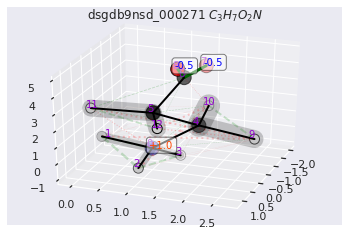

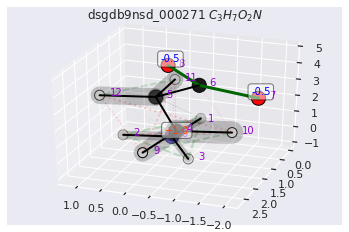

In [13]:
plot_molecule(alanine271, bonds=train_bonds, charges=train_charges, azim=20, elev=30)
plot_molecule(alanine271, bonds=train_bonds, charges=train_charges, azim=110, elev=30)


In [14]:
view3d_molecule(alanine271)

This molecule correspond zwitterionic form of [beta-alanine](https://en.wikipedia.org/wiki/%CE%92-Alanine)  $H_2N-CH_2-CH_2-COOH$ 


In [15]:
def pairlen(A,B):
    return np.linalg.norm([A.x.values-B.x.values, A.y.values-B.y.values, A.z.values-B.z.values])
m = structures[structures.molecule_name == alanine271]
N  = m[m.atom_index==0]
C4 = m[m.atom_index==4];   C5 = m[m.atom_index==5]; C6 = m[m.atom_index==6]
H1 = m[m.atom_index==1]; H2 = m[m.atom_index==2]; H3 = m[m.atom_index==3]; H10 = m[m.atom_index==10]; H11 = m[m.atom_index==11]
O7 = m[m.atom_index==7]; O8 = m[m.atom_index==8]
print("N-C4=", pairlen(N, C4))
print("N-C5=", pairlen(N, C5))
print("C4-C5", pairlen(C4, C5))
print("N-H1=", pairlen(N, H1))
print("N-H2=", pairlen(N, H2))
print("N-H3=", pairlen(N, H3))
print("C5-H1", pairlen(C5, H1))
print("C4-H3", pairlen(C4, H3))
print("O8-H11", pairlen(O8, H11))
print("O7-H10", pairlen(O7, H10))
print("C6-O7", pairlen(C6, O7))
print("C6-O8", pairlen(C6, O8))




N-C4= 1.5590353500168292
N-C5= 2.535376107322178
C4-C5 1.49493522434445
N-H1= 1.0223601271656313
N-H2= 1.0216903141866063
N-H3= 1.0248271259577322
C5-H1 2.7048121910011624
C4-H3 2.1785067413780648
O8-H11 2.8614612755927102
O7-H10 2.0809290902909208
C6-O7 1.2448154021368498
C6-O8 1.2257453897506847


The NH3 bonding seem consistent with the distance to its nearby `H`, but:
* C4 has only 3 covalent bonds
  * N-C4 = 1.56 and is in the upper range of realistic NC bonds : this may be the correct bond
* O8 has only one covalent bond 
  * none of the nearby atom is a candidate for bonding (expected O-H ~ 0.97)

I can't figure out how this could work to build an Alanine isomere from both `O` location.  
Is there a bug in the `structure` for this molecule?

## Distribution of `molecule_name` index

The index contained in the molecule name contains no information about molecule structure AFAIK, but looking at the distribution can provide hints about the train / test split.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


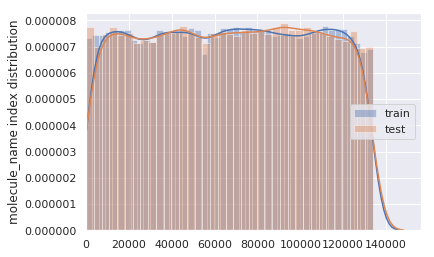

In [16]:
# select molecule index
for df, name in [(train_bonds, "train"), (test_bonds, "test")]:
    index_list = [float(name[10:] ) for name in df.molecule_name.unique() ]
    ax = sns.distplot(index_list, label=f"{name}")
    ax.set_ylabel("molecule_name index distribution")
ax.set_xlim(0, ax.get_xlim()[1])
legend = plt.legend()

Very well: molecule name index is equally distributed among both datasets!

# Molecules with cycles

In [17]:
train_cycles.head()

,molecule_name,cycle_index,cycle_seq,atom_index
0,dsgdb9nsd_000017,0,0,0
1,dsgdb9nsd_000017,0,1,2
2,dsgdb9nsd_000017,0,2,1
3,dsgdb9nsd_000044,0,0,1
4,dsgdb9nsd_000044,0,1,3


## Number of cycles per molecule

A high percentage of molecules in `train` and `test` dataset have 1 to 4 cycles. One again, train and test set are very homogenous for the cycle repartition.

In [18]:
def plot_count_ratio(df, x, y, hue, ax=None, add_text=False,
                     text_dy=0.05, text_rot=90, text_fmt="%.2f"):
    # https://github.com/mwaskom/seaborn/issues/1027      # normalize countplot
    prop_df = (df[x]
           .groupby(df[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())
    ax = sns.barplot(x=x, y=y, hue=hue, data=prop_df, ax=ax)
    if add_text:
        # https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width()/2.,
                    height + text_dy,
                    text_fmt % (height,),
                    ha="center", rotation = text_rot)
    return ax



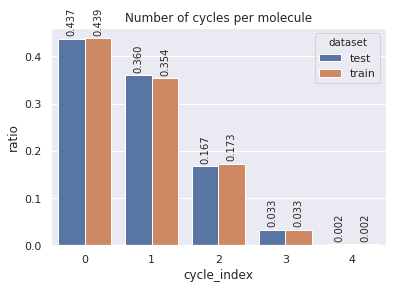

In [19]:
def plot_nbcycles():
    df1 = train_cycles.copy()
    df1["dataset"] = ["train"] * len(df1)
    df2 = test_cycles.copy()
    df2["dataset"] = ["test"] * len(df2)
    df = pd.concat([df1, df2])
    grp = (df.groupby(by=["molecule_name", "dataset"])
        .max()
        .reset_index())
    plot_count_ratio(grp, "cycle_index", "ratio", "dataset", add_text=True, text_fmt="%.3f")

plot_nbcycles()
txt = plt.title("Number of cycles per molecule")


## Number of atoms per cycle

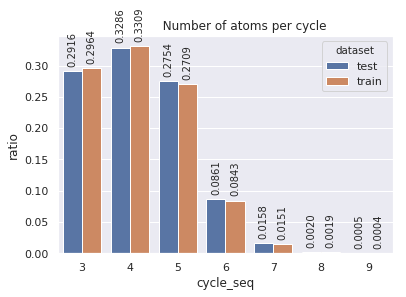

In [20]:
def plot_cycle_size():
    df1 = train_cycles.copy()
    df1["dataset"] = ["train"] * len(df1)
    df2 = test_cycles.copy()
    df2["dataset"] = ["test"] * len(df2)
    df = pd.concat([df1, df2])
    df.cycle_seq += 1
    grp = df.groupby(by=["molecule_name", "cycle_index", "dataset"]).max().reset_index()
    plot_count_ratio(grp, "cycle_seq", "ratio", "dataset", add_text=True, text_fmt="%.4f")
    
plot_cycle_size()
txt = plt.title("          Number of atoms per cycle")

Here again test and train are very consistent.   
Most of cycles count from 3 to 5 atoms while aromatic cycles account only for 8.5% of the total number of cycles.  

Curiously there are up to 9 atoms per cycles. The 9-cycle case is real as can be seen bellow (you can rotate the molecule in the bottom view to check by yourself). This one is really twisted.

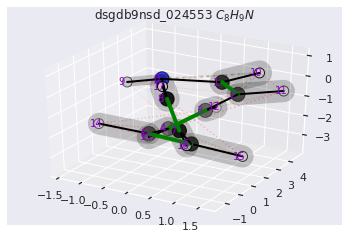

In [21]:
#grp = train_cycles.groupby(by=["molecule_name","cycle_seq"]).max().reset_index()
#grp[grp.cycle_seq == 8].molecule_name
plot_molecule("dsgdb9nsd_024553", bonds=train_bonds, charges=train_charges)
view3d_molecule("dsgdb9nsd_024553")

## Cycle composition

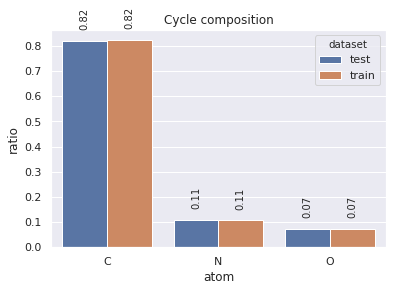

In [22]:
def plot_cycle_composition():
    df1 = train_cycles.copy()
    df1["dataset"] = ["train"] * len(df1)
    df2 = test_cycles.copy()
    df2["dataset"] = ["test"] * len(df2)
    df = pd.concat([df1, df2])
    
    # add atom name
    df = df.merge(how="left", on = ["molecule_name", "atom_index"], 
                   right = structures[["molecule_name", "atom_index", "atom"]])

    plot_count_ratio(df, "atom", "ratio", "dataset", add_text=True, text_dy=0.1, text_fmt="%.2f")
plot_cycle_composition()
txt = plt.title("Cycle composition")


No surprise here: cycles a made of 82% `C` atoms.

## A curiosity: cage-like molecule

There is one example of molecule with 4 cycles:  in pratice there are 5 cycles in this one but the last one remains undetected by the code as all its bonds are already included in other cycles.

This funky molecule name is *[prismane](https://fr.wikipedia.org/wiki/3-Prismane)* and has an interresting story as it was a candidate for benzene structures before it was discovered benzene was a cycle.

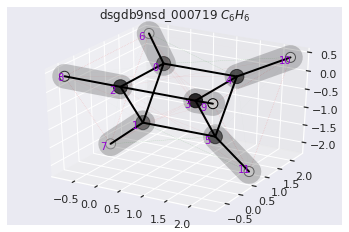

In [23]:
plot_molecule("dsgdb9nsd_000719", bonds=train_bonds, charges=train_charges)

# Write outputs



In [24]:
train_bonds.to_csv('train_bonds.csv', index=False)
train_charges.to_csv('train_charges.csv', index=False)
train_cycles.to_csv('train_cycles.csv', index=False)

test_bonds.to_csv('test_bonds.csv', index=False)
test_charges.to_csv('test_charges.csv', index=False)
test_cycles.to_csv('test_cycles.csv', index=False)


# What to do next?

* Compare with output from the [Open Babel](http://openbabel.org/wiki/Babel) software 
* Fix molecules with failed bonding (more than 2%)
  * some of them are cycles which build double bonds in the wrong order
  * some ionized groups are not well handled
* (**DONE**) Cycles plays an important role in deshielding of atoms.
The next step would be to build a cycle detection code in order to test new features related to cycles.
* (**DONE** by adding charge support) There are issues with some molecules: can a seasonned chemist guess how `dsgdb9nsd_000271` could be bonded correctly?


# Credits

Thanks to [M. Hermann](https://www.kaggle.com/mrhermann) for his advices about bond properties and the Zwitterionic ionized form.

Thanks to 